In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Program name

mark_forced_choice23_Bernstein_50_50_TTL

### Variable Definitions

- T   = event time stamp
- I   = event identity stamp

### Event Stamps

#### Trial bits
- 6   = Time-out, no initial head-entry in 10 sec  
- 7   = Time-out, no lever response choice in 10 sec  
- 19  = Time-out, no right lever response forced in 10 seconds
- 20  = Time-out, no left lever response forced in 10 seconds
- 27  = Time-out, no press in A(22) minutes
- 28  = Time-out, did not complete FR in A(21) minutes
- 3   = Rewarded rt lever response
- 4   = Rewarded lt lever response
- 15  = Time-out over
- 16  = ITI over
- 100 = Session termination

#### Within bits
- 10  = Initial head entry in trial  
- 11  = Subsequent head entries
- 8   = Lever choice right
- 9   = Lever choice left
- 21  = Forced trial right lever
- 22  = Forced trail left lever

#### ITI bits
- 5   = Reinforcement delivery #happens after trial is over
- 24  = Head entry during ITI
- 12  = Right lever press during time-out
- 13  = Left lever press during time-out
- 14  = Head entry during time-out

#### remainder
- 1   = Rt lever response in FR (if FR greater than 1 otherwise see codes 8,9,17,18,21,22)
- 2   = Lt lever response (if FR greater than 1 otherwise see codes 8,9,17,18,21,22)
- 17  = Initial forced trial lever press right
- 18  = Initial forced trial lever press left
- 23  = Choice trial
- 25  = ICS signal
- 26  = Extinction trial

### Variables check

Use these to check that correct parameters were entered into the Med-PC program for each file

- A(4) = Reward on right lever
- A(5) = Reward on left lever
- A(24) = Probabilistic lever (0 = None, 1 = Right, 2 = Left, 3 = Both)
- A(10) = Forced or choice (1 = forced, 2 = choice)


Don't Use

- A(1) = Intertrial interval calculated 
- A(2) = FR for right lever
- A(3) = FR for left lever
- A(6) = Delay on right lever
- A(7) = Delay on left lever
- A(8) = Lever choice (1 = right, -1 = left lever)
- A(9) = Maximum session length
- A(11) = Time to complete FR in seconds 
- A(12) = Time-out length
- A(13) = Maximum FR
- A(14) = Maximum intertrial interval (60 seconds default)
- A(15) = Minimum intertrial interval (30 seconds default)
- A(16) = Counter for trial number
- A(17) = Maximum number of trials (48 default)
- A(18) = Time limit defining a miss (10 seconds default)
- A(19) = Counter for completed right lever FRs
- A(20) = Counter for completed left lever FRs
- A(21) = Time-limit for completing an FR (minutes)
- A(22) = Time-limit for between presses; i.e., if a press is not given at least every A(22) minutes, a miss occurs
- A(23) = Repeat missed trials? (1:YES   2:NO)
- A(25) = Chosen from P list of reinforcement or no reinforcement
- A(26) = Counter for reinf probs list

### Functions

In [2]:
def get_file_info_PDT(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session, saves each accordingly
    import re
    
    task = file_path_name.split('/')[-1].split('_')[0]
    probability = file_path_name.split('/')[-1].split('_')[1].split('.')[0]
    sub_session = int(file_path_name.split('/')[-1].split('_')[1].split('.')[1])
    animal = int(file_path_name.split('/')[-1].split('_')[2])
    date = file_path_name.split('/')[-1].split('_')[3]

    return task, probability, sub_session, animal, date

In [3]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [4]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(event_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        elif re.search(time_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    time_data.append(float(element))
                i = i + 1
        else:
            i = i + 1

    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [5]:
def get_trial_times_PDT(events_and_times, ITITO_end_list, ITITO_start_list):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for trial related markers
    #e.g. conditioned stimulus onset and offset, ITI onset and offset
    #finds time_stamps for each start and end, puts into new dataframe
    import numpy as np
    import pandas as pd

    trial_starts = events_and_times[events_and_times['event_stamp'].isin(ITITO_end_list)]['time_stamp'].values + 0.01
    trial_starts = np.append(0, trial_starts)
    trial_ends = events_and_times[events_and_times['event_stamp'].isin(ITITO_start_list)]['time_stamp'].values
    ITITO_starts = events_and_times[events_and_times['event_stamp'].isin(ITITO_start_list)]['time_stamp'].values + 0.01
    ITITO_ends = events_and_times[events_and_times['event_stamp'].isin(ITITO_end_list)]['time_stamp'].values 

    times = pd.DataFrame(data = [trial_starts, trial_ends, ITITO_starts, ITITO_ends])
    times = times.T
    times.columns = ['trial_start', 'trial_end', 'ITI_start', 'ITI_end']
    times = times[0:24] #drop last trial (just final 1 sec ITI)
    
    return times

In [6]:
def create_trial_df(events_and_times, trial_times, trial_type):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    if trial_type == 'ITI':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['ITI_start'][i]) & (events_and_times['time_stamp'] <= trial_times['ITI_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['ITI_start'] = trial_times['ITI_start'][i]
            data['ITI_end'] = trial_times['ITI_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    elif trial_type == 'within':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['trial_start'] = trial_times['trial_start'][i]
            data['trial_end'] = trial_times['trial_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    
    return trial_data

In [7]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [8]:
def latency(trial_data, event_num, trial_type):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_ave.append(np.nan)
        else:
            if trial_type == 'ITI':
                latency_1st.append((data['time_stamp'] - data['ITI_start']).values[0]/100)
                latency_ave.append((data['time_stamp'] - data['ITI_start']).values.mean()/100)
            elif trial_type == 'within':
                latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
                latency_ave.append((data['time_stamp'] - data['trial_start']).values.mean()/100)
        i = i + 1
    
    return latency_1st, latency_ave

In [9]:
def create_session_df(trial_data, event_dic, trial_type):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    if trial_type == 'ITI':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['ITI_start'].unique(), trial_data.groupby('trial_#')['ITI_end'].unique()])
        times_df = times_df.T
    elif trial_type == 'within':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
        times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        if trial_type == 'ITI':
            trial_time = (times_df.iloc[i]['ITI_end'] - times_df.iloc[i]['ITI_start'])/100
        elif trial_type == 'within':
            trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])/100
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_ave')] = latency(trial_data, event, trial_type)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    
    return session_data

In [ ]:
def get_variables(array, variable_letter):
    #takes in array and the letter Med PC program uses to encode variables (parameters for behavioral program entered at time of exp)
    import re
    import numpy as np
    import pandas as pd

    i = 0
    variable_data = []
    while i < len(array):
        if re.search(str(variable_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    variable_data.append(float(element))
                i = i + 1
        i = i + 1
    
    variable_df = pd.DataFrame(data = variable_data)
    variable_df.columns = ['variables']
    
    return variable_df

In [ ]:
def check_parameter_entry(session_data, animal_info):
    
    #list of session names that we want to check (eg any session that used a probability)
    probabilities = ['75', '50', '25']
    
    animal = int(session_data['animal'].unique())
    
    #for 100 probability
    if session_data['probability'].unique() == '100':
        #determine high reward lever assigned to animal and fill in corresponding session data
        if animal_info[animal_info['animal'] == animal]['lever'].values == 1:
            session_data['rt_reward'] = 2
            session_data['lt_reward'] = 1
            session_data['prob_lever'] = 0
        if animal_info[animal_info['animal'] == animal]['lever'].values == 2:
            session_data['rt_reward'] = 1
            session_data['lt_reward'] = 2
            session_data['prob_lever'] = 0
            
    #for probabilities 75, 50, 25
    elif session_data['probability'].unique() in probabilities:
        #determine high reward lever assigned to animal and fill in corresponding session data
        if animal_info[animal_info['animal'] == animal]['lever'].values == 1:
            session_data['rt_reward'] = 2
            session_data['lt_reward'] = 1
            session_data['prob_lever'] = 1
        if animal_info[animal_info['animal'] == animal]['lever'].values == 2:
            session_data['rt_reward'] = 1
            session_data['lt_reward'] = 2
            session_data['prob_lever'] = 2
            
    #for 0 probability trial
    elif session_data['probability'].unique() == '0':
        #determine high reward lever assigned to animal and fill in corresponding session data
        if animal_info[animal_info['animal'] == animal]['lever'].values == 1:
            session_data['rt_reward'] = 0
            session_data['lt_reward'] = 1
            session_data['prob_lever'] = 0
        if animal_info[animal_info['animal'] == animal]['lever'].values == 2:
            session_data['rt_reward'] = 1
            session_data['lt_reward'] = 0
            session_data['prob_lever'] = 0
            
    else:
        return print('This is not a probability session.') 
            
    #assume entries were false until check determines otherwise
    rt_reward = False
    lt_reward = False
    force_choice = False
    prob_lever = False
    
    #get variables data containing parameter entries
    variables_df = get_variables(array, "A")

    #use varibales data and session data to determine if the correct parameters were entered
    if float(variables_df.iloc[4].values) in session_data['rt_reward'].unique():
        rt_reward = True

    if float(variables_df.iloc[5].values) in session_data['lt_reward'].unique():
        lt_reward = True
    
    if float(variables_df.iloc[24].values) in session_data['prob_lever'].unique():
        prob_lever = True
        
    if session_data['sub_session'].unique() == 1:
        sub_session = 1
    if session_data['sub_session'].unique() == 2:
        sub_session = 2 
    if float(variables_df.iloc[10].values) == sub_session:
        force_choice = True
    
    #print results
    return print('rt_reward:', rt_reward, '\n', 'lt_reward:', lt_reward, '\n', 'force_choice:', force_choice, '\n', 'prob_lever:', prob_lever, '\n')
    

### Read in meta data

In [14]:
#read animal info (lever assignment, group etc) into df

path_animal_info = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/assignments/round12_meta.xlsx'
    
animal_info = pd.read_excel(path_animal_info)
animal_info = pd.DataFrame(data = animal_info)

animal_info.head()

,animal,cage,group,lever
0,1215,SA319,4,right
1,1216,SA319,4,right
2,1217,SA319,4,right
3,1236,SA326,5,right
4,1237,SA326,5,right


### Read in task data

In [10]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD'

session_list = os.listdir(path)
print(len(session_list))
session_list[0:5]

260


['PDT_50.1_1237_210410',
 'PDT_0.2_1238_210413',
 'PDT_25.1_1221_210412',
 'PD_0.2_1123_210113',
 'PD_50.1_1130_210111']

In [11]:
file_paths = []
for file in session_list:
    file_path = path + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0:5]

260


['/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_50.1_1237_210410',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_0.2_1238_210413',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_25.1_1221_210412',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_0.2_1123_210113',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_50.1_1130_210111']

### Make trials df

In [15]:
%%time
final_data = pd.DataFrame()

#trial markers
ITITO_start_list = [3,4,6,7,19,20,27,28] #session ends with either a lever press or TO
ITITO_end_list = [15,16] #session starts when ITI or TO ends

#bit dics
bit_dic = {'right_lever_choice': 8, 'left_lever_choice': 9, 'right_lever_force': 21, 'left_lever_force': 22, 'HE_trial_start': 10, 'HE_trial': 11}
ITI_dic = {'reinforcement': 5, 'HE_ITI': 24, 'right_lever_TO': 12, 'left_lever_TO': 13, 'HE_TO': 14}

#check variables?
run_variables = False

for file in file_paths:
    print(file)
    
    if file.split('/')[-1] == '.DS_Store':
        continue
    
    #proccess file
    task, probability, sub_session, animal, date = get_file_info_PDT(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "I", "T")
    trial_times = get_trial_times_PDT(events_and_times, ITITO_end_list, ITITO_start_list)
    trial_data = create_trial_df(events_and_times, trial_times, 'within')
    ITItrial_data = create_trial_df(events_and_times, trial_times, 'ITI')
    session_data = create_session_df(trial_data, bit_dic, 'within')
    ITIsession_data = create_session_df(ITItrial_data, ITI_dic, 'ITI')
    
    #get animal metadata
    active_lever = animal_info[animal_info['animal'] == int(animal)]['lever'].iloc[0]
    group = int(animal_info[animal_info['animal'] == int(animal)]['group'])
    cage = animal_info[animal_info['animal'] == int(animal)]['cage'].iloc[0]
    
    #create pandas tidy df for within session
    session_data['task'] = [task]*(session_data.shape[0])
    session_data['part'] = ['within']*(session_data.shape[0]) 
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal'] = [animal]*(session_data.shape[0])
    session_data['probability'] = [probability]*(session_data.shape[0])
    session_data['sub_session'] = [sub_session]*(session_data.shape[0])
    session_data['active_lever'] = [active_lever]*(session_data.shape[0])
    session_data['group'] = [group]*(session_data.shape[0])
    session_data['cage'] = [cage]*(session_data.shape[0])
    
    session_data = session_data[['task', 'part', 'date', 'probability', 'sub_session', 'cage', 'animal', 'group', 
                                 'active_lever', 'trial_num', 'trial_duration', 
                                 'right_lever_choice_count', 'right_lever_choice_latency_1st', 
                                 'left_lever_choice_count', 'left_lever_choice_latency_1st', 
                                 'right_lever_force_count', 'right_lever_force_latency_1st', 
                                 'left_lever_force_count', 'left_lever_force_latency_1st', 
                                 'HE_trial_start_count', 'HE_trial_start_latency_1st', 
                                 'HE_trial_count', 'HE_trial_latency_1st']]
    
    #create pandas tidy df for within ITI
    ITIsession_data['task'] = [task]*(ITIsession_data.shape[0]) 
    ITIsession_data['part'] = ['ITI']*(ITIsession_data.shape[0]) 
    ITIsession_data['date'] = [date]*(ITIsession_data.shape[0])
    ITIsession_data['animal'] = [animal]*(ITIsession_data.shape[0])
    ITIsession_data['probability'] = [probability]*(ITIsession_data.shape[0])
    ITIsession_data['sub_session'] = [sub_session]*(ITIsession_data.shape[0])
    ITIsession_data['active_lever'] = [active_lever]*(ITIsession_data.shape[0])
    ITIsession_data['group'] = [group]*(ITIsession_data.shape[0])
    ITIsession_data['cage'] = [cage]*(ITIsession_data.shape[0])
    
    ITIsession_data = ITIsession_data[['task', 'part', 'date', 'probability', 'sub_session', 'cage', 'animal', 'group', 
                                       'active_lever', 'trial_num', 'trial_duration', 
                                       'reinforcement_count', 'reinforcement_latency_1st',
                                       'HE_ITI_count', 'HE_ITI_latency_1st',
                                       'right_lever_TO_count', 'right_lever_TO_latency_1st', 
                                       'left_lever_TO_count', 'left_lever_TO_latency_1st',
                                       'HE_TO_count', 'HE_TO_latency_1st']]

    #add to final data frame
    data_int = pd.concat([session_data, ITIsession_data], axis = 0, ignore_index=True)
    if final_data.shape[0] == 0:
        final_data = data_int
    else:
        final_data = pd.concat([final_data, data_int], axis = 0, ignore_index=True)

final_data.tail()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_50.1_1237_210410
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_0.2_1238_210413
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_25.1_1221_210412
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_0.2_1123_210113
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_50.1_1130_210111
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_100.2_1215_210407
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_25.2_1130_210112
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_75.1_1138_210108
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_100.2_

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_25.2_1240_210412
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_0.1_1117_200113
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_50.2_1121_210114
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_0.1_1236_210413
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_50.2_1241_210409
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_100.1_1217_210407
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_100.1_1117_210107
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_50.2_1222_210409
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_75.1

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_100.2_1222_210407
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_75.1_1119_200113
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_100.2_1241_210407
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_0.2_1130_200113
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_75.1_1144_210108
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_75.1_1135_210108
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_75.2_1236_210408
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_25.1_1216_210412
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_100.

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_0.1_1237_210413
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_75.1_1238_210408
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_100.1_1120_210107
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_0.1_1120_200113
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_75.2_1129_210108
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_50.2_1117_210111
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_25.1_1117_210112
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PDT_50.2_1221_210409
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/PD/PD_50.2_11

,task,part,date,probability,sub_session,cage,animal,group,active_lever,trial_num,trial_duration,right_lever_choice_count,right_lever_choice_latency_1st,left_lever_choice_count,left_lever_choice_latency_1st,right_lever_force_count,right_lever_force_latency_1st,left_lever_force_count,left_lever_force_latency_1st,HE_trial_start_count,HE_trial_start_latency_1st,HE_trial_count,HE_trial_latency_1st,reinforcement_count,reinforcement_latency_1st,HE_ITI_count,HE_ITI_latency_1st,right_lever_TO_count,right_lever_TO_latency_1st,left_lever_TO_count,left_lever_TO_latency_1st,HE_TO_count,HE_TO_latency_1st
12451,PD,ITI,210112,50,2,279,1118,4,right,18,0.0199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
12452,PD,ITI,210112,50,2,279,1118,4,right,19,51.9899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.7799,0.0,NaN,0.0,NaN,0.0,NaN
12453,PD,ITI,210112,50,2,279,1118,4,right,20,51.9899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,6.0,0.9499,0.0,NaN,0.0,NaN,0.0,NaN
12454,PD,ITI,210112,50,2,279,1118,4,right,21,51.9899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.7699,0.0,NaN,0.0,NaN,0.0,NaN
12455,PD,ITI,210112,50,2,279,1118,4,right,22,51.9899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.6599,0.0,NaN,0.0,NaN,0.0,NaN


In [21]:
#make new df with combined data
df_final = final_data.copy()

pd_final_trial = pd.DataFrame()

animals = df_final['animal'].unique()

for animal in animals:
    
    print(animal)
    
    #get animal data
    animal_data = df_final[df_final['animal'] == animal]
    
    if animal_data['active_lever'].unique() == 'right':
        animal_data['high_lever_count'] = animal_data['right_lever_choice_count']
        animal_data['high_lever_latency_1st'] = animal_data['right_lever_choice_latency_1st']
        animal_data['low_lever_count'] = animal_data['left_lever_choice_count']
        animal_data['low_lever_latency_1st'] = animal_data['left_lever_choice_latency_1st']
        animal_data['high_lever_TO_count'] = animal_data['right_lever_TO_count']
        animal_data['high_lever_TO_latency_1st'] = animal_data['right_lever_TO_latency_1st']
        animal_data['low_lever_TO_count'] = animal_data['left_lever_TO_count']
        animal_data['low_lever_TO_latency_1st'] = animal_data['left_lever_TO_latency_1st']
        
    elif animal_data['active_lever'].unique() == 'left':
        animal_data['high_lever_count'] = animal_data['left_lever_choice_count']
        animal_data['high_lever_latency_1st'] = animal_data['left_lever_choice_latency_1st']
        animal_data['low_lever_count'] = animal_data['right_lever_choice_count']
        animal_data['low_lever_latency_1st'] = animal_data['right_lever_choice_latency_1st']
        animal_data['high_lever_TO_count'] = animal_data['left_lever_TO_count']
        animal_data['high_lever_TO_latency_1st'] = animal_data['left_lever_TO_latency_1st']
        animal_data['low_lever_TO_count'] = animal_data['right_lever_TO_count']
        animal_data['low_lever_TO_latency_1st'] = animal_data['right_lever_TO_latency_1st']
        
    pd_final_trial = pd_final_trial.append(animal_data)
        
pd_final_trial.reset_index(inplace=True, drop=True)    

pd_final_trial = pd_final_trial[['task', 'part', 'date', 'probability', 'sub_session', 'cage', 'animal', 
                                       'group', 'active_lever', 'trial_num', 'trial_duration',
                                       'reinforcement_count', 'reinforcement_latency_1st',
                                       'HE_trial_start_count', 'HE_trial_start_latency_1st',
                                       'HE_trial_count', 'HE_trial_latency_1st', 
                                       'HE_ITI_count', 'HE_ITI_latency_1st',
                                       'HE_TO_count', 'HE_TO_latency_1st',
                                       'high_lever_count', 'high_lever_latency_1st',
                                       'low_lever_count', 'low_lever_latency_1st', 
                                       'high_lever_TO_count', 'high_lever_TO_latency_1st', 
                                       'low_lever_TO_count', 'low_lever_TO_latency_1st']].sort_values(['task', 'part', 'sub_session', 'probability', 'group', 'animal', 'trial_num',])

print(pd_final_trial.shape)
pd_final_trial.head()

1237
1238
1221
1123
1130
1215
1138
1240
1223
1119
1217
1118
1241
1222
1135
1239
1144
1136
1128
1124
1216
1129
1121
1120
1236
1117
(12456, 29)


,task,part,date,probability,sub_session,cage,animal,group,active_lever,trial_num,trial_duration,reinforcement_count,reinforcement_latency_1st,HE_trial_start_count,HE_trial_start_latency_1st,HE_trial_count,HE_trial_latency_1st,HE_ITI_count,HE_ITI_latency_1st,HE_TO_count,HE_TO_latency_1st,high_lever_count,high_lever_latency_1st,low_lever_count,low_lever_latency_1st,high_lever_TO_count,high_lever_TO_latency_1st,low_lever_TO_count,low_lever_TO_latency_1st
12098,PD,ITI,200113,0,1,279,1117,4,right,0,51.9999,1.0,0.0099,NaN,NaN,NaN,NaN,1.0,1.1899,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
12099,PD,ITI,200113,0,1,279,1117,4,right,1,51.9999,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
12100,PD,ITI,200113,0,1,279,1117,4,right,2,51.9999,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.7199,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
12101,PD,ITI,200113,0,1,279,1117,4,right,3,51.9999,1.0,0.0099,NaN,NaN,NaN,NaN,11.0,0.5799,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
12102,PD,ITI,200113,0,1,279,1117,4,right,4,51.9999,0.0,NaN,NaN,NaN,NaN,NaN,4.0,17.5799,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


### Make session df

In [66]:
#make new df with high reward vs low reward columns by session

pd_final_session = pd.DataFrame()

animals = pd_final_trial['animal'].unique()

for animal in animals:
    
    #get animal data
    animal_data = pd_final_trial[pd_final_trial['animal'] == animal]
    
    #loop through probabilities
    probabilities = animal_data['probability'].unique()
    for prob in probabilities:
        animal_data_session = animal_data[animal_data['probability'] == prob]
        #loop through sub sessions
        sub_sessions = animal_data_session['sub_session'].unique()
        for sub in sub_sessions:
            animal_data_sub_session = animal_data_session[animal_data_session['sub_session'] == sub]
            #loop through parts
            parts = animal_data_sub_session['part'].unique()            
            for part in parts:
                animal_data_sub_session_part = animal_data_sub_session[animal_data_sub_session['part'] == part] 
                    
                pd_df_session_int = pd.DataFrame()
    
                #fill meta data
                pd_df_session_int['task'] = animal_data_sub_session_part['task'].unique()
                pd_df_session_int['part'] = part
                pd_df_session_int['date'] = animal_data_sub_session_part['date'].unique()
                pd_df_session_int['probability'] = prob
                pd_df_session_int['sub_session'] = sub
                pd_df_session_int['cage'] = animal_data_sub_session_part['cage'].unique()
                pd_df_session_int['animal'] = animal
                pd_df_session_int['group'] = animal_data_sub_session_part['group'].unique()
                pd_df_session_int['active_lever'] = animal_data_sub_session_part['active_lever'].unique()
                pd_df_session_int['trial_count'] = animal_data_sub_session_part['trial_num'].max()

                #compute and fill session data
                pd_df_session_int['reinforcement_count'] = animal_data_sub_session_part['reinforcement_count'].sum()
                pd_df_session_int['reinforcement_latency_1st'] = animal_data_sub_session_part['reinforcement_latency_1st'].mean()
        
                pd_df_session_int['HE_trial_start_latency_1st'] = animal_data_sub_session_part['HE_trial_start_latency_1st'].mean()
                pd_df_session_int['HE_trial_count'] = animal_data_sub_session_part['HE_trial_count'].sum()
                pd_df_session_int['HE_trial_latency_1st'] = animal_data_sub_session_part['HE_trial_latency_1st'].mean()
                pd_df_session_int['HE_ITI_count'] = animal_data_sub_session_part['HE_ITI_count'].sum()
                pd_df_session_int['HE_ITI_latency_1st'] = animal_data_sub_session_part['HE_ITI_latency_1st'].mean()
                pd_df_session_int['HE_TO_count'] = animal_data_sub_session_part['HE_TO_count'].sum()
                pd_df_session_int['HE_TO_latency_1st'] = animal_data_sub_session_part['HE_TO_latency_1st'].mean()
                                    
                pd_df_session_int['high_lever_count'] = animal_data_sub_session_part['high_lever_count'].sum()
                pd_df_session_int['high_lever_latency_1st'] = animal_data_sub_session_part['high_lever_latency_1st'].mean()
                pd_df_session_int['low_lever_count'] = animal_data_sub_session_part['low_lever_count'].sum()
                pd_df_session_int['low_lever_latency_1st'] = animal_data_sub_session_part['low_lever_latency_1st'].mean()
    
                pd_df_session_int['high_reward_perc'] = pd_df_session_int['high_lever_count'] / \
                    (pd_df_session_int['high_lever_count'] + pd_df_session_int['low_lever_count']) * 100
                pd_df_session_int['high_reward_ratio'] = (pd_df_session_int['high_lever_latency_1st'] / pd_df_session_int['low_lever_latency_1st']) * 100
            
                pd_final_session = pd_final_session.append(pd_df_session_int)
        
pd_final_session.reset_index(inplace=True, drop=True)
pd_final_session = pd_final_session.sort_values(['task', 'part', 'sub_session', 'probability', 'group', 'animal'])    
print(pd_final_session.shape)
pd_final_session.head()

(520, 25)


,task,part,date,probability,sub_session,cage,animal,group,active_lever,trial_count,reinforcement_count,reinforcement_latency_1st,HE_trial_start_latency_1st,HE_trial_count,HE_trial_latency_1st,HE_ITI_count,HE_ITI_latency_1st,HE_TO_count,HE_TO_latency_1st,high_lever_count,high_lever_latency_1st,low_lever_count,low_lever_latency_1st,high_reward_perc,high_reward_ratio
0,PD,ITI,200113,0,1,279,1117,4,right,23,12.0,0.0099,NaN,0.0,NaN,225.0,1.726422,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
20,PD,ITI,210114,0,1,279,1118,4,right,23,12.0,0.0099,NaN,0.0,NaN,146.0,1.595552,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
40,PD,ITI,210116,0,1,280,1119,4,left,23,12.0,0.0099,NaN,0.0,NaN,420.0,0.555552,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
60,PD,ITI,200113,0,1,280,1120,4,left,22,6.0,0.0099,NaN,0.0,NaN,70.0,1.826823,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
80,PD,ITI,210116,0,1,280,1121,4,left,23,12.0,0.0099,NaN,0.0,NaN,259.0,1.108991,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN


In [ ]:
exclude_no_100 = [1217, 1221, 1222, 1236, 1239, 1240]

### Melt df

In [67]:
pd_final_session.columns.values
pd_final_session_tidy = pd_final_session.drop(['task', 'date', 'cage'], axis=1)
pd_final_session_tidy_melt = pd_final_session_tidy.set_index(['part', 'group', 'animal', 'active_lever', 'sub_session', 'probability']).unstack(-1).reset_index()
pd_final_session_tidy_melt = pd_final_session_tidy_melt.sort_values(['part', 'sub_session', 'group', 'animal'])

In [54]:
pd_final_trial.to_csv('PD_trial.csv', index=False)
pd_final_session.to_csv('PD_session.csv', index=False)
pd_final_session_tidy_melt.to_csv('PD_melt.csv', index=False)

### Viz

In [57]:
pd_final_session_2wi.head(1)

,task,part,date,probability,sub_session,cage,animal,group,active_lever,trial_count,reinforcement_count,reinforcement_latency_1st,HE_trial_start_latency_1st,HE_trial_count,HE_trial_latency_1st,HE_ITI_count,HE_ITI_latency_1st,HE_TO_count,HE_TO_latency_1st,high_lever_count,high_lever_latency_1st,low_lever_count,low_lever_latency_1st,high_reward_perc,high_reward_ratio
3,PD,within,200113,0,2,279,1117,4,right,23,0.0,NaN,8.799488,13.0,10.024356,0.0,NaN,0.0,NaN,12.0,10.960742,12.0,8.793233,50.0,10.972517


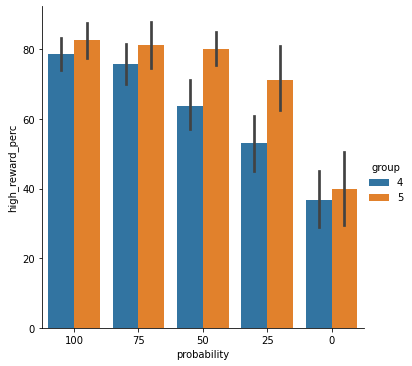

In [71]:
pd_final_session_2 = pd_final_session[pd_final_session['sub_session'] == 2]
pd_final_session_2wi = pd_final_session_2[pd_final_session_2['part'] == 'within']

exclude_no_100 = [1116, 1217, 1221, 1222, 1236, 1239, 1240]

pd_final_session_2_exclude = pd_final_session_2wi[~pd_final_session_2wi['animal'].isin(exclude_no_100)]

sns.catplot(x='probability', y='high_reward_perc', data=pd_final_session_2_exclude, hue='group', kind='bar', ci=68, 
           order=['100', '75', '50', '25', '0'])

plt.show()

### Single for refactor

In [ ]:
run_variables = False

file_path = file_paths[2]
print('file_path:', '\n', file_path, '\n')

task, probability, sub_session, animal, date = get_file_info_PDT(file_path)
print('date:', date, 'animal:', animal, 'task:', task, 'probability:', probability, 'sub_session:', sub_session, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "I", "T")
print(events_and_times.head(), '\n')

ITITO_start_list = [3,4,6,7,19,20,27,28] #session ends with either a lever press or TO
ITITO_end_list = [15,16] #session starts when ITI or TO ends
trial_times = get_trial_times_PDT(events_and_times, ITITO_end_list, ITITO_start_list)
print(trial_times.head(), '\n')

trial_data = create_trial_df(events_and_times, trial_times, 'within')
print(trial_data.head(), '\n')

ITI_trial_data = create_trial_df(events_and_times, trial_times, 'ITI')
print(ITI_trial_data.head(), '\n')

bit_dic = {'right_lever_choice': 8, 'left_lever_choice': 9, 'right_lever_force': 21, 'left_lever_force': 22, 'HE_trial_start': 10, 'HE_trial': 11}
session_data = create_session_df(trial_data, bit_dic, 'within')

ITI_dic = {'reinforcement': 5, 'HE_ITI': 24, 'right_lever_TO': 12, 'left_lever_TO': 13, 'HE_TO': 14}
ITI_data = create_session_df(ITI_trial_data, ITI_dic, 'ITI')